# Memory usage
Show memory usage and runtimes for standard functions in this repo. With larger datasets, the methods take on the order of seconds, so we only run them once, rather than taking an average (we're more interested in the memory usage than time anyway).

Use `memory-profiler` package [link](https://pypi.org/project/memory-profiler/), function `memory_usage` which samples memory usage at a regular interval (default 0.1s). This may miss spikes that occur between samples. The help message for this function is shown below. 

We use binary prefixes, usually Gibibytes: $1024^{3}$ bytes, etc. (Memory-profiler uses MiB by default.)

Genetic data is usually stored as `int` on disk (either 0 or 1), but are converted to `float32`, which is necessary for the analysis. We show graphs on usage  over time + max usage, for two datasets:
- `reduced_20` with shape `(860, 447245)`, about 1.43 GiB
- `all` with shape `(4816, 447245)`, about 


In [9]:

from memory_profiler import memory_usage

import util
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
from statsmodels.stats.correlation_tools import cov_nearest
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
data_path ='./data'
import importlib
importlib.reload(util)
from statsmodels.stats.correlation_tools import cov_nearest
import logging
logging.basicConfig(level=logging.INFO)

save_path = "/home/jmhb/robust-dim-reduction-popgen/results/"
;

''

# Info on `memory_profiler.memory_usage`
[Package Link](https://pypi.org/project/memory-profiler/)

In [10]:
help(memory_usage)

Help on function memory_usage in module memory_profiler:

memory_usage(proc=-1, interval=0.1, timeout=None, timestamps=False, include_children=False, multiprocess=False, max_usage=False, retval=False, stream=None, backend=None, max_iterations=None)
    Return the memory usage of a process or piece of code
    
    Parameters
    ----------
    proc : {int, string, tuple, subprocess.Popen}, optional
        The process to monitor. Can be given by an integer/string
        representing a PID, by a Popen object or by a tuple
        representing a Python function. The tuple contains three
        values (f, args, kw) and specifies to run the function
        f(*args, **kw).
        Set to -1 (default) for current process.
    
    interval : float, optional
        Interval at which measurements are collected.
    
    timeout : float, optional
        Maximum amount of time (in seconds) to wait before returning.
    
    max_usage : bool, optional
        Only return the maximum memory u

# Utility functions 

In [64]:
def plot_2_usages(mem_usage_1, mem_usage_2, timestep=0.1, dset_1='reduced_20',dset_2='all'):
    f, axs = plt.subplots(1,2, figsize=(12,2))
    axs[0].plot(np.arange(len(mem_usage_1))/10, np.array(mem_usage_1)/1024, c='k')
    axs[1].plot(np.arange(len(mem_usage_2))/10, np.array(mem_usage_2)/1024, c='k')
    axs[0].set(ylim=[0,None], xlabel="time, seconds", ylabel="Mem usage GiB"
               , title='Dataset {}'.format(dset_1))
    axs[1].set(ylim=[0,None], xlabel="time, seconds", ylabel="Mem usage GiB"
               , title='Dataset {}'.format(dset_2))
    
    return f, axs

In [50]:
# country origin data
fname_country_lookup = '/home/jmhb/robust-dim-reduction-popgen/data/country-origins.csv'

country_lookup = pd.read_csv(fname_country_lookup, sep=",")
country_lookup = country_lookup.set_index('Geographic-Origin')
country_lookup.index = pd.Series(country_lookup.index).replace('Russian','Russia')

def get_data(dataset='reduced_20', N_subset=None):
    """
    @dataset: 'all' (for all 4800 samples) or `reducer_20`
    @N: take the first N_subset samples. Default `None` keeps all elements. 
    """
    if dataset=='all':
        
        # all data 
        data_files = np.load('/home/projects/POPRES/POPRES_non-reduced_phased_allEur.npz', allow_pickle=True)
        gt_matrix = data_files['gt_matrix'][:N_subset]
        ind_IDs = data_files['ind_IDs'][:N_subset]
        labels = data_files['labels'][:N_subset]
        gt_matrix = gt_matrix.astype(np.float32)
        df = pd.DataFrame(gt_matrix)
        df_labels = pd.DataFrame(labels)
        df_labels.columns = ['label']

    elif dataset=='reduced_20':
        fname_data = "/home/projects/POPRES/POPRES_non-reduced_phased_20.dat"
        fname_labels = "/home/projects/POPRES/POPRES_non-reduced_phased_20_labels.txt"
        with open(fname_data, 'rb') as pf: data = pickle.load(pf)[:N_subset]
        df = pd.DataFrame(data)
        df_labels=pd.read_csv(fname_labels, sep='\t')[:N_subset]
    
    return df, df_labels


# Results: Reading data

Dataset `Reduced 20`
Shape (860, 447245)
Max usage 32.35 GiB
Size of df 1.43 GiB
Size of df_labels 0.013 MiB
--------------------------------------------------------------------------------
Dataset `all`
Shape (4816, 447245)
Max usage 41.45 GiB
Size of df 8.02 GiB
Size of df_labels 0.037 MiB


''

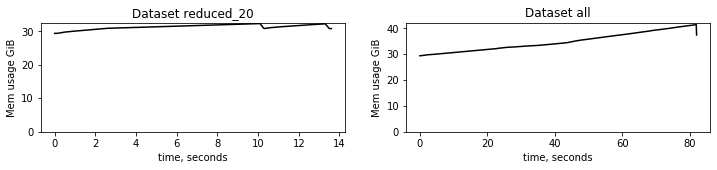

In [65]:
kwargs_1 = {'dataset':'reduced_20', 'N_subset':None}
kwargs_2 = {'dataset':'all', 'N_subset':None}

mem_usage_1, (df_1, df_labels_1) = memory_usage((get_data, [], kwargs_1), retval=True)
mem_usage_2, (df_2, df_labels_2) = memory_usage((get_data, [], kwargs_2), retval=True)

print("Dataset `{}`".format('Reduced 20'))
print("Shape {}".format(df_1.shape))
print("Max usage {:.2f} GiB".format(max(mem_usage_1)/1024))
print("Size of df {:.2f} GiB".format(df_1.values.nbytes/1024**3))
print("Size of df_labels {:.3f} MiB".format(df_labels_1.values.nbytes/1024**2))


print('-'*80)
print("Dataset `{}`".format('all'))
print("Shape {}".format(df_2.shape))
print("Max usage {:.2f} GiB".format(max(mem_usage_2)/1024))
print("Size of df {:.2f} GiB".format(df_2.values.nbytes/1024**3))
print("Size of df_labels {:.3f} MiB".format(df_labels_2.values.nbytes/1024**2))

f, axs = plot_2_usages(mem_usage_1, mem_usage_2)
;


# Results: Cleaning and building matrix
`clean`: remove features with no variance over the samples 

`build_matrix`: center and normalize

Dataset `Reduced 20`
Max usage, clean 30.85 GiB
Shape before cleaning (860, 447245)
Shape after cleaning (860, 417968)
Size before cleaning 1.43 GiB
Size after cleaning 1.34 GiB
--------------------------------------------------------------------------------
Dataset `all`
Max usage, clean 26.87 GiB
Shape before cleaning (4816, 447245)
Shape after cleaning (4816, 438720)
Size before cleaning 8.02 GiB
Size after cleaning 7.87 GiB


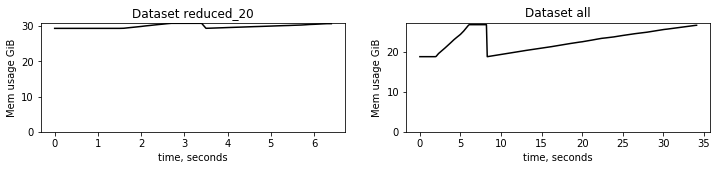

In [67]:
msg_1 = "Shape before cleaning P{}"

mem_usage_clean_1, (df_clean_1) = memory_usage((util.clean,[df_1],{}), retval=True)
mem_usage_clean_2, (df_clean_2) = memory_usage((util.clean,[df_2],{}), retval=True)

plot_2_usages(mem_usage_clean_1, mem_usage_clean_2)

print("Dataset `{}`".format('Reduced 20'))
print("Max usage, clean {:.2f} GiB".format(max(mem_usage_clean_1)/1024))
print("Shape before cleaning {}".format(df_1.shape))
print("Shape after cleaning {}".format(df_clean_1.shape))
print("Size before cleaning {:.2f} GiB".format(df_1.values.nbytes/1024**3))
print("Size after cleaning {:.2f} GiB".format(df_clean_1.values.nbytes/1024**3))

print('-'*80)
print("Dataset `{}`".format('all'))
print("Max usage, clean {:.2f} GiB".format(max(mem_usage_clean_2)/1024))
print("Shape before cleaning {}".format(df_2.shape))
print("Shape after cleaning {}".format(df_clean_2.shape))
print("Size before cleaning {:.2f} GiB".format(df_2.values.nbytes/1024**3))
print("Size after cleaning {:.2f} GiB".format(df_clean_2.values.nbytes/1024**3))

Dataset `Reduced 20`
Max usage, build 21.38 GiB
--------------------------------------------------------------------------------
Dataset `all`
Max usage, build 35.84 GiB


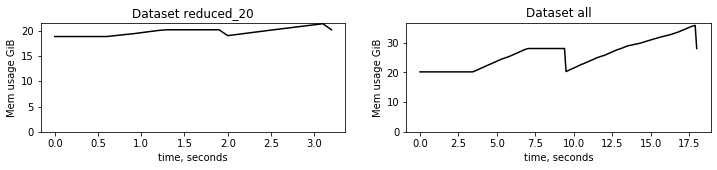

In [70]:
mem_usage_build_1, (M_1) = memory_usage((util.build_matrix,[df_clean_1],{}), retval=True)
mem_usage_build_2, (M_2) = memory_usage((util.build_matrix,[df_clean_2],{}), retval=True)

plot_2_usages(mem_usage_build_1, mem_usage_build_2)

print("Dataset `{}`".format('Reduced 20'))
print("Max usage, build {:.2f} GiB".format(max(mem_usage_build_1)/1024))

print('-'*80)
print("Dataset `{}`".format('all'))
print("Max usage, build {:.2f} GiB".format(max(mem_usage_build_2)/1024))

# Results: Build distance matrix
This includes calls to `clean` and `build_matrix`. After that it calls `sklearn.metrics.pairwise.euclidean_distances`. 

The profiling charts so that the max usage peaks when `clean` and `build` are called 

Dataset `reduced`
Max usage 31.99
Size of distance matrix 0.01 GiB
--------------------------------------------------------------------------------
Dataset `all`
Max usage 51.57
Size of distance matrix 0.17 GiB


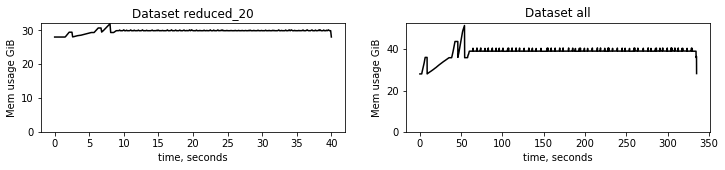

In [75]:
mem_usage_dist_1, (df_dist_1) = memory_usage((util.build_distance_matrix,[df_1],{}), retval=True)
mem_usage_dist_2, (df_dist_2) = memory_usage((util.build_distance_matrix,[df_2],{}), retval=True)

plot_2_usages(mem_usage_dist_1, mem_usage_dist_2)

print('Dataset `reduced`')
print("Max usage {:.2f}".format(max(mem_usage_dist_1)/1024))
print("Size of distance matrix {:.2f} GiB".format(df_dist_1.values.nbytes/1024**3))

print('-'*80)
print('Dataset `all`')
print("Max usage {:.2f}".format(max(mem_usage_dist_2)/1024))
print("Size of distance matrix {:.2f} GiB".format(df_dist_2.values.nbytes/1024**3))

## Normalized 
This also makes a call to `clean` and `build`.

Dataset `reduced`
Max usage 37.19 GiB
--------------------------------------------------------------------------------
Dataset `all`
Max usage 77.21 GiB


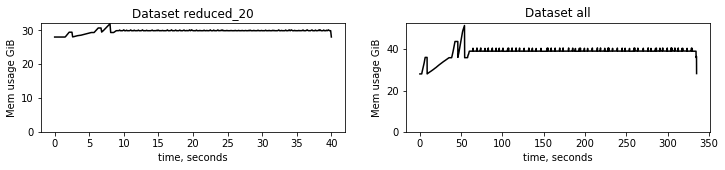

In [80]:
mem_usage_norm_1, (res_norm_1) = memory_usage((util.do_normalized_pca,[df_1, df_dist_1],{}), retval=True)
mem_usage_norm_2, (res_norm_2) = memory_usage((util.do_normalized_pca,[df_2, df_dist_2],{}), retval=True)

plot_2_usages(mem_usage_dist_1, mem_usage_dist_2)

print('Dataset `reduced`')
print("Max usage {:.2f} GiB".format(max(mem_usage_norm_1)/1024))
print('-'*80)
print('Dataset `all`')
print("Max usage {:.2f} GiB".format(max(mem_usage_norm_2)/1024))

## Reslts: Supervized
Is almost the same as normalized, except it multiplies an intermediate matrix elementwise by one of two constants.

Dataset `reduced`
Max usage 37.53 GiB
--------------------------------------------------------------------------------
Dataset `all`
Max usage 77.42 GiB


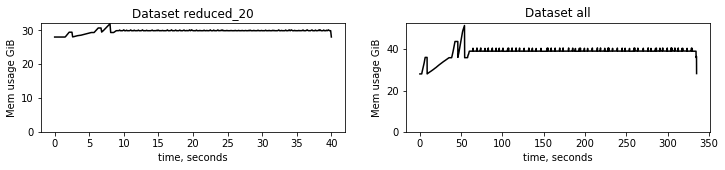

In [84]:
args_sup_1 = [df_1, df_dist_1]
kwargs_sup_1={'supervised':True, 'supervised_t':0, 'labels':df_labels_1}
args_sup_2 = [df_2, df_dist_2]
kwargs_sup_2={'supervised':True, 'supervised_t':0, 'labels':df_labels_2}

mem_usage_sup_1, (res_sup_1) = memory_usage((util.do_normalized_pca, args_sup_1,kwargs_sup_1), retval=True)
mem_usage_sup_2, (res_sup_2) = memory_usage((util.do_normalized_pca, args_sup_2,kwargs_sup_2), retval=True)

plot_2_usages(mem_usage_dist_1, mem_usage_dist_2)

print('Dataset `reduced`')
print("Max usage {:.2f} GiB".format(max(mem_usage_sup_1)/1024))
print('-'*80)
print('Dataset `all`')
print("Max usage {:.2f} GiB".format(max(mem_usage_sup_2)/1024))

# Experiments
Space to test memory usage of function calls. 

In [103]:
n=1e6
n=int(n)
x_64 = np.random.random((n))
x_32 = x_64.copy().astype(np.float32)
print("Type {}, size {:.2f} MiB".format(x_64.dtype, x_64.nbytes/1024**2))
print("Type {}, size {:.2f} MiB".format(x_32.dtype, x_32.nbytes/1024**2))

Type float64, size 7.63 MiB
Type float32, size 3.81 MiB
